# Use OSMnx to calculate street network indicators

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd

%matplotlib inline
ox.__version__

'1.3.0'

# Calculate basic street network measures (topological and geometric)

In [4]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place("Piedmont, California, USA"))
stats["circuity_avg"]

1.0755397383911285

In [6]:
# get the street network for a place, and its area in square meters
place = "Piedmont, California, USA"
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type="drive")

In [7]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             351
m                                                                             945
k_avg                                                                    5.384615
edge_length_total                                                      112573.274
edge_length_avg                                                        119.125158
streets_per_node_avg                                                     2.954416
streets_per_node_counts            {0: 0, 1: 34, 2: 0, 3: 269, 4: 45, 5: 2, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.09686609686609686, 2: 0.0, 3: 0....
intersection_count                                                            317
street_length_total                                                     58265.588
street_segment_count                                                          495
street_length_avg                                                      117.708259
circuity_avg    

Caddeler/kavşak sayıları ve oranları, istatistik diktesinin içinde iç içe yerleştirilmiş diktelerdir. Bu istatistikleri bir panda veri çerçevesine dönüştürmek için (birden çok ağı birbiriyle karşılaştırmak/analiz etmek için), önce bu iç içe dikteleri paketinden çıkarın:

In [8]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats["streets_per_node_counts"].items():
    stats["{}way_int_count".format(k)] = count
for k, proportion in stats["streets_per_node_proportions"].items():
    stats["{}way_int_prop".format(k)] = proportion

# delete the no longer needed dict elements
del stats["streets_per_node_counts"]
del stats["streets_per_node_proportions"]

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name="value")).round(3)

,value
n,351.000
m,945.000
k_avg,5.385
edge_length_total,112573.274
edge_length_avg,119.125
streets_per_node_avg,2.954
intersection_count,317.000
street_length_total,58265.588
street_segment_count,495.000
street_length_avg,117.708


# Inspect betweenness centrality

In [9]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.get_digraph(G), weight="length")
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.3212116250511666)

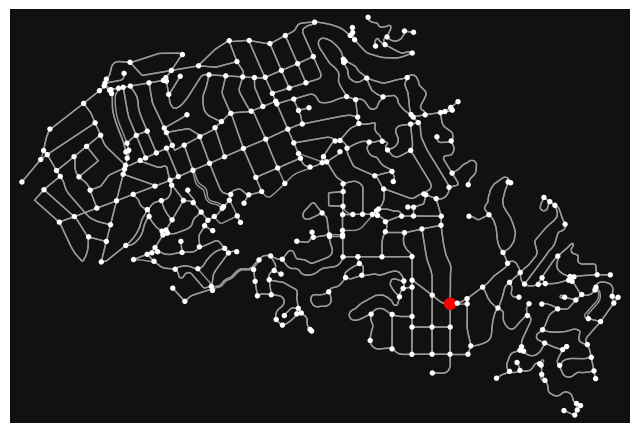

In [10]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

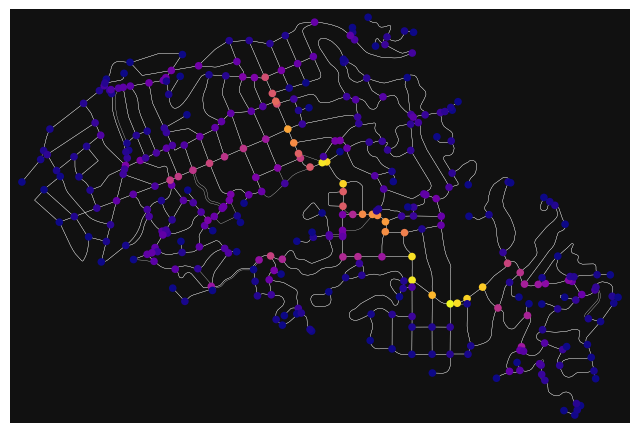

In [11]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)